# Language prediction

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from datasets import Dataset
# from transformers import Trainer, TrainingArguments
from IPython.display import display, clear_output
from copy import deepcopy

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
device = 'cpu'

In [15]:
embd_data = np.load('./data/embd_data.npy')
txt_data = pd.read_csv('./data/text_data.csv')

In [16]:
txt_data

,themes,English1,English2,English3,Spanish1,Spanish2,Spanish3,French1,French2,French3,...,Polish3,Czech1,Czech2,Czech3,Ukrainian1,Ukrainian2,Ukrainian3,Hebrew1,Hebrew2,Hebrew3
0,Love and Relationships,Love is a beautiful and complex emotion that h...,Relationships thrive when there is open and ho...,Love knows no boundaries and can be found in v...,El amor es una emoción hermosa y compleja que ...,Las relaciones prosperan cuando hay una comuni...,El amor no conoce fronteras y puede encontrars...,L'amour est une émotion belle et complexe qui ...,Les relations s'épanouissent lorsque la commun...,L'amour ne connaît pas de frontières et peut ê...,...,Miłość nie zna granic i może przybierać różne ...,"Láska je krásná a složitá emoce, která má moc ...","Vztahy prosperují, když existuje otevřená a up...",Láska nezná hranice a může se objevit v různýc...,"Любов - це прекрасна і складна емоція, яка має...","Відносини процвітають, коли є відкрита і чесна...",Любов не знає меж і може бути знайдена у різни...,אהבה היא רגש יפה ומורכב שיש לו את הכוח להביא ש...,"היחסים מתפתחים כשיש תקשורת פתוחה וכנה, כבוד מש...",אהבה אינה מכירה גבולות וניתן למצואה בצורות שונ...
1,Nature and the Environment,The lush green forests are not only a sight to...,The delicate balance of ecosystems is being di...,It is our responsibility to protect and preser...,Los exuberantes bosques verdes no solo son un ...,El delicado equilibrio de los ecosistemas está...,Es nuestra responsabilidad proteger y preserva...,Les forêts luxuriantes et verdoyantes ne sont ...,Le fragile équilibre des écosystèmes est pertu...,Il est de notre responsabilité de protéger et ...,...,Naszym obowiązkiem jest chronić i zachować prz...,"Husté zelené lesy nejsou jen pohledem, ale tak...",Jemné rovnováhy ekosystémů jsou narušovány lid...,Je naší odpovědností chránit a zachovávat přír...,"Буйні зелені ліси - це не тільки вид, який вар...",Ніжна рівновага екосистем порушується людською...,Нашою відповідальністю є захист і збереження п...,היערות הירוקים והצומחים אינם רק נוף נפלא להביט...,האיזון העדין של האקוסיסטמות מופר בפעילויות אנו...,זהו עלינו להגן ולשמור על הטבע למען הדורות הבאי...
2,Technology and the Future,With advancements in artificial intelligence a...,As we continue to explore the possibilities of...,The rapid development of virtual reality and a...,Con los avances en inteligencia artificial y a...,A medida que continuamos explorando las posibi...,El rápido desarrollo de las tecnologías de rea...,Avec les avancées de l'intelligence artificiel...,Alors que nous continuons à explorer les possi...,Le développement rapide des technologies de ré...,...,Szybki rozwój technologii rzeczywistości wirtu...,S rozvojem umělé inteligence a strojového učen...,Pokračujeme v prozkoumávání možností obnovitel...,Rychlý vývoj technologií virtuální reality a r...,Завдяки досягненням у сфері штучного інтелекту...,Поки ми продовжуємо досліджувати можливості ві...,Швидкий розвиток технологій віртуальної реальн...,"עם התקדמות בבינה מלאכותית ולמידת מכונה, עתיד ה...",כך שאנחנו ממשיכים לחקור את האפשרויות של מקורות...,התפתחות מהירה של טכנולוגיות מציאות מדומה ומציא...
3,Identity and Self-Discovery,Self-discovery is a lifelong journey that allo...,"Exploring different cultures, beliefs, and exp...",The process of self-discovery often involves q...,El autodescubrimiento es un viaje de toda la v...,"Explorar diferentes culturas, creencias y expe...",El proceso de autodescubrimiento a menudo impl...,La découverte de soi est un voyage tout au lon...,"Explorer différentes cultures, croyances et ex...",Le processus de découverte de soi implique sou...,...,Proces odkrywania samego siebie często wiąże s...,"Sebepoznání je celoživotní cesta, která jednot...","Prozkoumávání různých kultur, přesvědčení a zk...",Proces sebepoznání často zahrnuje otázky k soc...,"Самовідкриття - це життєва подорож, яка дозвол...","Дослідження різних культур, вірувань та досвід...",Процес самовідкриття часто включає у себе пита...,גילוי עצמי הוא מ

In [17]:
num_classes = int((txt_data.shape[1] - 1) / 3)
num_classes

23

In [18]:
class_names = [c[:-1] for c in list(txt_data.columns)[1::3]]
class_names

['English',
 'Spanish',
 'French',
 'German',
 'Italian',
 'Dutch',
 'Russian',
 'Chinese',
 'Japanese',
 'Korean',
 'Arabic',
 'Portuguese',
 'Swedish',
 'Norwegian',
 'Danish',
 'Finnish',
 'Hindi',
 'Turkish',
 'Greek',
 'Polish',
 'Czech',
 'Ukrainian',
 'Hebrew']

In [233]:
flat_embd = []
flat_classes = []
flat_ind_classes = []
id2class = [c[:-1] for c in list(txt_data.columns)[1:]]
for col in range(len(id2class)):
    flat_embd.extend(embd_data[:, col])
    flat_classes.extend([id2class[col]] * embd_data.shape[0])
    lbl_inds = [0.0 for _ in range(num_classes)]
    lbl_inds[class_names.index(id2class[col])] = 1.0
    flat_ind_classes.extend([lbl_inds] * embd_data.shape[0])

In [234]:
print(len(flat_embd), len(flat_classes), len(flat_ind_classes))

1449 1449 1449


In [235]:
dataset = Dataset.from_dict({
    'input_ids': flat_embd,
    'labels': flat_ind_classes,
    'class_name': flat_classes
})

In [236]:
dataset['labels'][0]

[1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [237]:
dataset['class_name'][0]

'English'

In [238]:
ds = dataset.train_test_split(test_size=0.1)

In [239]:
len(ds['test']['input_ids'][0])

1536

In [240]:
ds['test']['labels'][0]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [241]:
class Torch_dataset(torch.utils.data.Dataset):

    def __init__(self, input_ids, labels, class_name):
        self.input_ids = torch.tensor(input_ids).float()
        self.labels = torch.tensor(labels).float()
        self.class_name = class_name

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.labels[idx]

In [242]:
train_ds = Torch_dataset(ds['train']['input_ids'], ds['train']['labels'], ds['train']['class_name'])
test_ds = Torch_dataset(ds['test']['input_ids'], ds['test']['labels'], ds['train']['class_name'])

## Model

In [388]:
class Lang_detect(nn.Module):
    def __init__(self, inp_dim=1536, num_classes=23):
        super().__init__()
        # self.fc1 = nn.Linear(inp_dim, num_classes)
        self.fc1 = torch.rand((inp_dim, num_classes)) / 600
        self.fc1.requires_grad_()
        self.fc1 = nn.Parameter(self.fc1)
        self.activation = nn.Sigmoid()

    def forward(self, input_ids):
        x = torch.matmul(input_ids, self.fc1)
        # x = self.fc1(input_ids)
        return x

In [389]:
model = Lang_detect().to(device)

In [390]:
o = model(torch.rand((3, 1536)).to(device))

In [391]:
o

tensor([[0.6368, 0.6515, 0.6576, 0.6525, 0.6466, 0.6430, 0.6607, 0.6439, 0.6586,
         0.6544, 0.6494, 0.6486, 0.6445, 0.6683, 0.6435, 0.6574, 0.6426, 0.6384,
         0.6747, 0.6517, 0.6689, 0.6634, 0.6661],
        [0.6232, 0.6290, 0.6429, 0.6442, 0.6279, 0.6314, 0.6507, 0.6215, 0.6447,
         0.6395, 0.6297, 0.6362, 0.6277, 0.6553, 0.6373, 0.6517, 0.6304, 0.6192,
         0.6502, 0.6416, 0.6395, 0.6417, 0.6574],
        [0.6269, 0.6416, 0.6533, 0.6554, 0.6425, 0.6420, 0.6675, 0.6402, 0.6463,
         0.6535, 0.6424, 0.6500, 0.6422, 0.6578, 0.6521, 0.6555, 0.6455, 0.6295,
         0.6585, 0.6403, 0.6575, 0.6604, 0.6601]], grad_fn=<MmBackward0>)

## manual training

In [247]:
Batch_size = 16

In [248]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=Batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=Batch_size, drop_last=True)

In [392]:
# criterion = nn.BCELoss()
criterion = nn.MSELoss()
best_model = deepcopy(model)
best_val_loss = 50

val_step = 500 // Batch_size
metrics = pd.DataFrame([], columns=['step', 'train_loss', 'val_loss'])
step = 0

In [393]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [410]:

for e in range(100):
    for st, (input_ids, labels) in enumerate(train_dl):
        input = input_ids.to(device)
        target = labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        step += 1

        if step % val_step == 0:
            with torch.no_grad():
                val_loss = []
                for input_ids, labels in test_dl:
                    input = input_ids.to(device)
                    target = labels.to(device)
                    output = model(input)
                    loss_v = criterion(output, target)
                    val_loss.append(loss_v.item())
            val_loss = sum(val_loss) / len(val_loss)

            met_len = len(metrics)
            metrics.loc[met_len] = [step * Batch_size, loss.item(), val_loss]
            clear_output(wait=True)
            display(metrics)

            if best_val_loss >= val_loss:
                best_model = deepcopy(model)
                best_val_loss = val_loss
        

,step,train_loss,val_loss
0,496.0,0.041954,0.041813
1,992.0,0.040326,0.040494
2,1488.0,0.038999,0.039391
3,1984.0,0.038194,0.038397
4,2480.0,0.037147,0.037467
...,...,...,...
788,391344.0,0.001049,0.003931
789,391840.0,0.000921,0.003924
790,392336.0,0.001202,0.003930
791,392832.0,0.000854,0.003929


In [411]:
best_val_loss

0.003918444556701515

<Axes: >

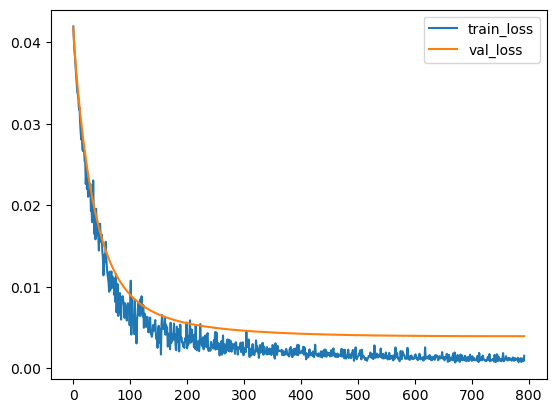

In [412]:
metrics[['train_loss', 'val_loss']].plot()

## Testing

In [5]:
import openai
import os

In [6]:
with open(os.path.join(os.path.dirname(os.path.abspath("")), "OpenAI_API_my.txt"), 'r') as f:
    openai.api_key = f.readlines()[0]

In [7]:
embedding_model = "text-embedding-3-small"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191
completion_model = "gpt-3.5-turbo"

In [8]:
def get_embedding(text: str, model="text-embedding-3-small", **kwargs):
    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")
    response = openai.embeddings.create(input=[text], model=model, **kwargs)
    return response.data[0].embedding

In [9]:
def chatgpt(text, model="gpt-3.5-turbo"):
    response = client.chat.completions.create(model=model,
        messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": text},
        ],
        temperature=0)
    return response.choices[0].message.content

In [269]:
texts = [
    ['Last guests on Shabbat were Prishman and Kogan families', 'English'],
    ['Very simple sentence bout text writing', 'English'],
    ['Słońce wschodziło majestatycznie nad horyzontem, rzucając ciepłe światło na śpiące miasteczko. Ptaki ćwierkały melodyjnie, witając nowy dzień. Aromat świeżo parzonej kawy unosił się w powietrzu, kusząc mieszkańców do rozpoczęcia porannych rytuałów.', 'Polish'],
    ['כשהעיר התעוררה לאט-לאט, הרחובות התמלאו בשקט ובהמולה של החיים היומיומיים. ילדים צחקו ושיחקו, מוסיפים צלילי שמחה להתחלה של היום.', 'Hebrew'],
    ['כְּשֶׁהָעִיר הִתְעוֹרֵרָה לְאַט-לְאַט, הַרְחוֹבוֹת הִתְמַלְּאוּ בַּשְׁקֵט וּבַהֲמוֹלָה שֶׁל הַחַיִּים הַיּוֹמִיִּים. יְלָדִים צָחֲקוּ וְשִׂיחֲקוּ, מוֹסִיפִים צְלָילֵי שִׂמְחָה לְהַתְחָלַת הַיּוֹם.', 'Hebrew'],
    ['古老的钟楼敲响，标志着又一个小时的流逝，而小镇则进入了日常的节奏。市场摊位开始开张，摆出五颜六色的水果和蔬菜，新鲜的样子吸引着购物者。当地面包店飘来烘焙食品的香味，诱惑着路人们，带来温暖而令人愉悦的气息。', 'Chinese'],
    ['Старинная часовня пробила час, отмечая прошедший час, когда город вошел в свои ежедневные ритмы. Рыночные лавки начали открываться, выставляя красочные фрукты и овощи, привлекая покупателей свежестью. Запах выпечки донесся из местной пекарни, искушая прохожих своим теплым, уютным ароматом.', 'Russian'],
]

In [10]:
texts = [
    ['document: 237 Daf, 2 Line, 1 Comment:\nובזכות אבי אמותיהן. וכגון שלאבי אמותיהן לא היו בנים כי אם בנות דאם לא כן היו בנים יורשין וא"ת ומי החזיר להן וי"ל כגון שהיו אחים לאבי אמותיהן שהיו להם בנים והחזירום בנים לאבותיהם וחלקו בשוה:\n237 Daf, 3 Line, 1 Comment:', 'Hebrew'],
    ['עומדים בכל חזרת הש"צ, עומדים כשהש"צ אומר "אלהינו ואלהי אבותינו", ועליהם תבא ברכת טוב.', 'Hebrew'],
    ["""document: 2, 3 Chapter, 6 Mishnah, 1 Comment:\nהגבאים – גובי המס מטעם מלכות רומי, והם בחזקת עמי הארץ. כן שנינו: "חבר שנעשה גבוי (=גבאי) דוחין אותו מחבורתו (=מחבירותו)" (תוס', דמאי פ"ג ה"ד; ירו', שם פ"ב ה"ג, כג ע"א; בבלי, בכורות לא ע"א). הגבאים נחשבו משתפי פעולה עם השלטונות וחכמים ראו בהם דוגמה מובהקת לעמי ארצות, שהרי אדם מהוגן לא יקבל על עצמו תפקיד של גבאי (ראו להלן). הגבאים נכנסים כדי לערוך שומה או כדי לגבות בכוח חוב לשלטונות. הם עורכים בבית חיפוש, ולכן יש להניח שנגעו בכל החפצים.\n2, 3 Chapter, 6 Mishnah, 2 Comment:""", 'Hebrew'],
    ["""document: .(קדושין ל"ו א')\n6 Deuteronomy, 14 Chapter, 1 Paragraph, 2 Comment:\nבנים אתם. חביבים ישראל שנקראו בנים למקום, וחבה יתרה נודעת להם שנקראו לו בנים בכי יש אב שאע"פ שהוא אוהב את בנו אבל אינו מראה לו את רגש אהבתו בגלוי, אבל האוהב את בנו אהבה עזה מאד אינו יכול להטמין את הרגש בלבו ומראה לו זה בגלוי, וכך היא אהבתם של הקב"ה לישראל, וזהו חבה יתירה שהודיע להם שכבנים המה לו.\n [אבות פ"ג מי"ד].\n6 Deuteronomy, 14 Chapter, 1 Paragraph, 3 Comment:""", 'Hebrew'],
]

In [11]:
for txt in texts:
    embd = get_embedding(txt[0])
    txt.append(embd)

In [12]:
texts[0]

['document: 237 Daf, 2 Line, 1 Comment:\nובזכות אבי אמותיהן. וכגון שלאבי אמותיהן לא היו בנים כי אם בנות דאם לא כן היו בנים יורשין וא"ת ומי החזיר להן וי"ל כגון שהיו אחים לאבי אמותיהן שהיו להם בנים והחזירום בנים לאבותיהם וחלקו בשוה:\n237 Daf, 3 Line, 1 Comment:',
 'Hebrew',
 [0.0471414290368557,
  0.07260023802518845,
  0.017327824607491493,
  0.010739799588918686,
  -0.011064632795751095,
  0.020616760477423668,
  0.002333470154553652,
  0.0019325041212141514,
  -0.015317918732762337,
  0.0018170360708609223,
  0.046451155096292496,
  -0.03414809703826904,
  0.015612298622727394,
  0.03630011901259422,
  -0.0496588870882988,
  0.0007797267171554267,
  0.08445665240287781,
  -0.015774715691804886,
  -0.028402607887983322,
  0.0213983915746212,
  0.005354673136025667,
  0.04498940706253052,
  0.017469938844442368,
  -0.03690917789936066,
  0.03343752399086952,
  -0.04013720899820328,
  0.018109453842043877,
  -0.006004340015351772,
  0.062449194490909576,
  -0.0640733614563942,
  0.038330

---

In [160]:
print(f'Pred: {class_names[21]:>10} | GT: {lang:<10} | {class_names[21]==lang}')

Pred:  Ukrainian | GT: Russian    | False


In [413]:
outs = []
for txt, lang, embd in texts:
    with torch.no_grad():
        out = best_model(torch.tensor([embd]))
    outs.append(deepcopy(out[0].numpy()))
    val, ind = out.max(1)
    print(f'Pred: {class_names[ind]:>10} | GT: {lang:<10} | {class_names[ind]==lang}')

Pred:    English | GT: English    | True
Pred:    English | GT: English    | True
Pred:     Polish | GT: Polish     | True
Pred:     Hebrew | GT: Hebrew     | True
Pred:     Hebrew | GT: Hebrew     | True
Pred:    Chinese | GT: Chinese    | True
Pred:    Russian | GT: Russian    | True


In [414]:
outs[0]

array([ 5.27559876e-01, -1.87447481e-02,  1.02162617e-03,  1.42435338e-02,
       -4.28462215e-03, -1.20371848e-01,  1.70205221e-01,  7.41387010e-02,
       -1.04977690e-01, -2.26505399e-01, -1.73954114e-01, -4.88889664e-02,
        1.18427701e-01, -1.06355295e-01, -4.23949212e-04, -1.19603217e-01,
       -8.10743347e-02,  8.63214135e-02, -3.62637974e-02,  2.27071732e-01,
        3.43467593e-02, -2.10728392e-01,  4.64147389e-01], dtype=float32)

---

## Convert to numpy

In [415]:
np_weights = best_model.fc1.detach().numpy()

In [19]:
outs_np = []
for txt, lang, embd in texts:
    embd_np = np.array([embd])
    out = np.matmul(embd_np, np_weights)
    outs_np.append(deepcopy(out[0]))
    ind = out.argmax()
    print(f'Pred: {class_names[ind]:>10} | GT: {lang:<10} | {class_names[ind]==lang}')

Pred:     Hebrew | GT: Hebrew     | True
Pred:     Hebrew | GT: Hebrew     | True
Pred:     Hebrew | GT: Hebrew     | True
Pred:     Hebrew | GT: Hebrew     | True


In [20]:
outs_np[0]

array([ 0.30871455, -0.06452807,  0.02197781,  0.10918197,  0.06545138,
       -0.0340499 ,  0.06178174,  0.04627484, -0.03831401,  0.02995633,
       -0.19686091,  0.02199637,  0.08529983, -0.10025745,  0.00190103,
       -0.15720381, -0.11114146, -0.00653013,  0.00645151, -0.01256477,
        0.16726202, -0.25612523,  0.77175634])

---
# Save model

In [418]:
np.save('./model/lang_classifier_23.npy', np_weights)

In [419]:
with open('./model/class_names_23.txt', 'w', encoding='utf-8') as f:
    f.write(','.join(class_names))

## Load np model

In [13]:
np_weights = np.load('./model/lang_classifier_23.npy')

## Language entity investigation

In [420]:
class_names[0]

'English'

In [421]:
np_weights[:, 0]

array([ 0.03353395,  0.0201375 ,  0.27596584, ..., -0.07241154,
       -0.01558116,  0.09617699], dtype=float32)

In [267]:
np_weights[:, 0].max()

0.3792497

In [226]:
def inv_sigmoid(x):
    return np.log(x / (1 - x))
    # return np.log(x) - np.log(1 - x)

sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [204]:
np_weights[:, 0].sum()

28.116814

In [205]:
eng_entity = np_weights[:, 0] / np_weights[:, 0].sum()

In [208]:
eng_entity

array([-0.08907621, -0.10900167,  0.15226981, ..., -0.12088709,
        0.04367885,  0.21157645], dtype=float32)

In [228]:
eng_entity

array([0.07554057, 0.04458367, 0.9863644 , ..., 0.03232799, 0.7734876 ,
       0.997398  ], dtype=float32)

In [422]:
np.save('./entities/english2.npy', eng_entity)